In [1]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)


# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = []
# Reading the train data and storing them in a single dataframe
data_files = ['Youtube01-Psy.csv','Youtube02-KatyPerry.csv','Youtube03-LMFAO.csv','Youtube04-Eminem.csv','Youtube05-Shakira.csv']
for file in data_files:
    data = pd.read_csv(file)
    train_data.append(data)
train_data = pd.concat(train_data)

In [3]:
## Function which drops the given features from the given dataframe
def drop_features(features,data):
    data.drop(features,axis=1,inplace=True)

Cleaning the data
- Drop insignificant columns
- Process the contents of data
- Extract features from the data

In [4]:
# drop insignificant columns
drop_features(['COMMENT_ID','AUTHOR','DATE'],train_data)

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   CONTENT  1956 non-null   object
 1   CLASS    1956 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.8+ KB


In [6]:
train_data.head()

,CONTENT,CLASS
0,"Huh, anyway check out this you[tube] channel: kobyoshi02",1
1,"Hey guys check out my new channel and our first vid THIS IS US THE MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   CONTENT  1956 non-null   object
 1   CLASS    1956 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.8+ KB


In [8]:
# Lowercase all words
train_data['processed_content'] = train_data['CONTENT'].apply(lambda x: x.lower())

In [9]:
drop_features(['CONTENT'],train_data)
train_data.reset_index(drop=True, inplace=True)

In [10]:
train_data['CLASS'].value_counts()

1    1005
0     951
Name: CLASS, dtype: int64

In [11]:
import re
train_data['processed_content'] = train_data['processed_content'].apply(lambda x: " ".join(re.findall("[A-Za-z]+", x.lower())))
train_data.head()

,CLASS,processed_content
0,1,huh anyway check out this you tube channel kobyoshi
1,1,hey guys check out my new channel and our first vid this is us the monkeys i m the monkey in the white shirt please leave a like comment and please subscribe
2,1,just for test i have to say murdev com
3,1,me shaking my sexy ass on my channel enjoy
4,1,watch v vtarggvgtwq check this out


In [12]:
# Remove rows with blank values
train_data = train_data[~train_data['processed_content'].str.strip().eq('')]
train_data.reset_index(drop=True, inplace=True)

In [13]:
# tokenize all comments in the data
comments_token = train_data['processed_content'].apply(lambda x: x.split())
print('Average word length of comments is {0:.0f}.'.format(np.mean(comments_token.apply(lambda x: len(x)))))
print('Max word length of comments is {0:.0f}.'.format(np.max(comments_token.apply(lambda x: len(x)))))
print('Min word length of comments is {0:.0f}.'.format(np.min(comments_token.apply(lambda x: len(x)))))

Average word length of comments is 17.
Max word length of comments is 218.
Min word length of comments is 1.


In [14]:
# Stop Words Removal
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 

comments_rsw = []
for comment_token in comments_token:
    filtered_comment = [w for w in comment_token if not w in stop_words] 
    comments_rsw.append(filtered_comment)

In [15]:
# Lemmatization
def lemmatization(dataset):
    lemma = nltk.WordNetLemmatizer()
    comments_lemma = []
    for comment in comments_rsw:
        comment_lemma = [lemma.lemmatize(w) for w in comment]
        comments_lemma.append(comment_lemma)
    return comments_lemma

# Words lemmatization
comments_lemma = lemmatization(comments_rsw)

In [16]:
#Train test split
labels = train_data['CLASS'].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(comments_lemma, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=labels)

In [17]:
from sklearn.feature_extraction.text import HashingVectorizer

# Create bag of words
X_train_untokenized = [' '.join(comment) for comment in X_train]
X_test_untokenized = [' '.join(comment) for comment in X_test]

# Use HashingVectorizer
vect = HashingVectorizer(n_features=10000)  # Set the desired number of features
x_train_hash = vect.transform(X_train_untokenized)
x_test_hash = vect.transform(X_test_untokenized)

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import PassiveAggressiveClassifier

# Define the hyperparameters grid
param_grid = {
    'C': [i / 1000 for i in range(1, 1001)],
    'loss': ['hinge', 'squared_hinge']
}

# Create an instance of PassiveAggressiveClassifier
clf = PassiveAggressiveClassifier()

# Perform grid search with cross-validation
cv_split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=cv_split)
grid_search.fit(x_train_hash, y_train)

# Print the best hyperparameters and the corresponding score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

In [18]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

# Create an instance of PassiveAggressiveClassifier
clf = PassiveAggressiveClassifier(C=0.01, loss='squared_hinge')

# Fit the classifier on the training data
clf.fit(x_train_hash, y_train)

# Predict labels for the train data
y_train_pred = clf.predict(x_train_hash)

# Predict labels for the test data
y_pred = clf.predict(x_test_hash)

In [19]:
confusion_matrix(y_train,y_train_pred)

array([[748,   5],
       [  5, 798]], dtype=int64)

In [20]:
train_report = classification_report(y_train,y_train_pred)
print("Train Classification Report:\n", train_report)

Train Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       753
           1       0.99      0.99      0.99       803

    accuracy                           0.99      1556
   macro avg       0.99      0.99      0.99      1556
weighted avg       0.99      0.99      0.99      1556



In [21]:
confusion_matrix(y_test,y_pred)

array([[181,   7],
       [  9, 192]], dtype=int64)

In [22]:
test_report = classification_report(y_test,y_pred)
print("Test Classification Report:\n", test_report)

Test Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       188
           1       0.96      0.96      0.96       201

    accuracy                           0.96       389
   macro avg       0.96      0.96      0.96       389
weighted avg       0.96      0.96      0.96       389



In [23]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
cm = confusion_matrix(y_test,y_pred)

# Extract the TP, TN, FP, FN from the confusion matrix
TP = cm[1, 1]  # true positive 
TN = cm[0, 0]  # true negative
FP = cm[0, 1]  # false positive
FN = cm[1, 0]  # false negative

# Calculate precision, recall, and F1-score
precision = TP / float(TP + FP)
recall = TP / float(TP + FN)

# Print the evaluation metrics
print("Accuracy =", (TP + TN) / float(TP + TN + FP + FN))
print("Precision =", TP / float(TP + FP))
print("Recall =", TP / float(TP + FN))
print("F1-Score =", 2 * (precision * recall) / (precision + recall))

Accuracy = 0.9588688946015425
Precision = 0.964824120603015
Recall = 0.9552238805970149
F1-Score = 0.96


Online Learning

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer

addl_df = pd.read_csv('5000 YT comments.csv', encoding='Windows-1252')
# drop insignificant columns
drop_features(['Name', 'Time', 'Likes', 'Reply Count'], addl_df)
addl_df = addl_df.rename(columns={'Comment': 'CONTENT', 'Spam': 'CLASS'})

# Preprocess the additional data
addl_df['processed_content'] = addl_df['CONTENT'].apply(lambda x: x.lower())
addl_df['processed_content'] = addl_df['processed_content'].apply(lambda x: " ".join(re.findall("[A-Za-z]+", x.lower())))
addl_df = addl_df[~addl_df['processed_content'].str.strip().eq('')]
addl_df.reset_index(drop=True, inplace=True)
addl_df['processed_content'] = addl_df['processed_content'].apply(lambda x: [WordNetLemmatizer().lemmatize(w) for w in x.split() if w not in stop_words])

# Split the data into train and test sets
train_df, test_df, train_labels, test_labels = train_test_split(addl_df['processed_content'], addl_df['CLASS'], test_size=0.2, random_state=42)

# Transform the data using the existing vectorizer
x_train_hash = vect.transform([' '.join(comment) for comment in train_df]).toarray()
y_train = train_labels.values

x_test_hash = vect.transform([' '.join(comment) for comment in test_df]).toarray()
y_test = test_labels.values

# Update the model with additional data
x_addl_hash = vect.transform([' '.join(comment) for comment in train_df]).toarray()
y_addl = train_labels.values

clf.set_params(C=0.1, loss= 'squared_hinge')
clf.partial_fit(x_addl_hash, y_addl)

# Perform prediction on the updated model
y_train_pred = clf.predict(x_train_hash)
y_pred = clf.predict(x_test_hash)
y_addl_pred = clf.predict(x_addl_hash)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.90      0.91       493
           1       0.90      0.92      0.91       499

    accuracy                           0.91       992
   macro avg       0.91      0.91      0.91       992
weighted avg       0.91      0.91      0.91       992



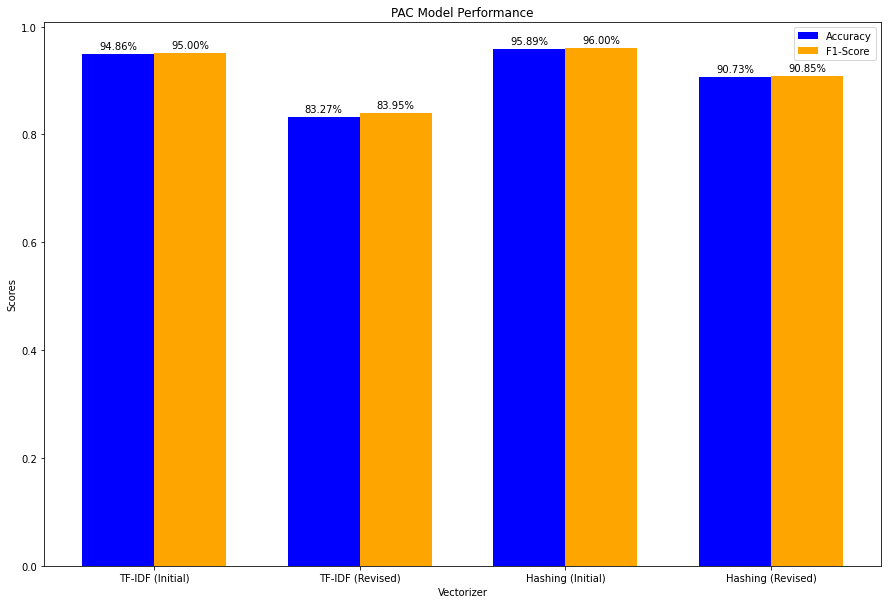

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Data
vectorizers = ['TF-IDF', 'TF-IDF', 'Hashing', 'Hashing']
models = ['Initial', 'Revised', 'Initial', 'Revised']
accuracy = [0.9485861182519281, 0.8326612903225806, 0.9588688946015425, 0.907258064516129]
f1_score = [0.95, 0.839458413926499, 0.96, 0.9085487077534792]

# Bar positions
x = np.arange(len(vectorizers))
width = 0.35

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))
rects1 = ax.bar(x - width/2, accuracy, width, label='Accuracy', color='blue')
rects2 = ax.bar(x + width/2, f1_score, width, label='F1-Score', color='orange')


# X-axis ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(['TF-IDF (Initial)', 'TF-IDF (Revised)', 'Hashing (Initial)', 'Hashing (Revised)'])

# Axis labels and title
ax.set_xlabel('Vectorizer')
ax.set_ylabel('Scores')
ax.set_title('PAC Model Performance')

# Add percentage numbers on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2%}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Legend
ax.legend()

# Display the plot
plt.show()
